In [147]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from random import choices

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC




# Cleaning function

#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text

# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove

#Remove stopwords & Punctuations
def remove_stopwords(text,STOPWORDS):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
    
def remove_punct(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct

def clean_text(text):

    STOPWORDS = set(stopwords.words('english'))

    cleaned = remove_urls(text) # Remove Urls
    cleaned = remove_html(cleaned) # Remove HTML links
    cleaned = remove_punct(cleaned) # Remove Punctuations
    cleaned = lower(cleaned) # Lower casing
    cleaned = remove_num(cleaned) # Remove numbers
    cleaned = remove_stopwords(cleaned,STOPWORDS) # Remove stopwords

    return cleaned

In [148]:
df = pd.read_csv('data/reviews.csv').fillna('') # Reads csv with data
df.rename({'Recommended IND':'Recommended'}, axis=1, inplace=True) # Rename column 
df['Review'] = df['Title'] + ' ' + df['Review Text'] # Concatenate title and review text

df = df[['Recommended', 'Review']]

print('Number of empty reviews:')
print(df['Review'].apply(lambda x: len(x)==0).sum())
print('\nNumber of 0 and 1 in Recommended :')
print(df['Recommended'].value_counts())

# Before anything, let's split into test and train data.

X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Recommended'], test_size=0.25, random_state=27)

Number of empty reviews:
0

Number of 0 and 1 in Recommended :
1    19314
0     4172
Name: Recommended, dtype: int64


In [149]:
# Gather X_train and X_test into a dataframe
df_X = pd.concat([X_train, y_train], axis=1)

df_majority = df_X[(df_X['Recommended']==1)]
df_minority = df_X[(df_X['Recommended']==0)]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=len(df_majority) , # to match majority class
                                 random_state=42)  # reproducible results
                                 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

Text(0.5, 0.98, 'Avant upsampling')

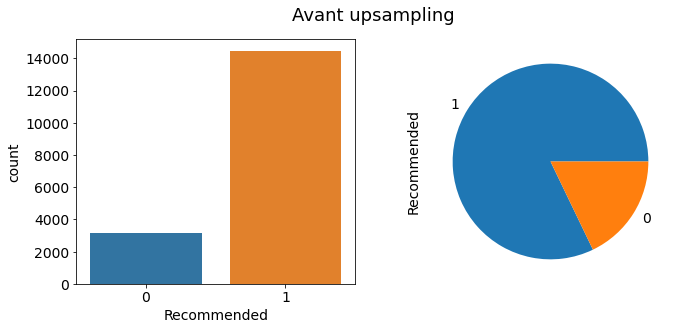

In [150]:
# Uneven distribution of reviews

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

fig = plt.figure(figsize = (11, 4.5))
plt.subplot(1, 2, 1)
sns.countplot(x=df_X['Recommended'])

plt.subplot(1, 2, 2)
df_X['Recommended'].value_counts().plot.pie(y='Class')
fig.suptitle('Avant upsampling', fontsize=18)

Text(0.5, 0.98, 'Après upsampling')

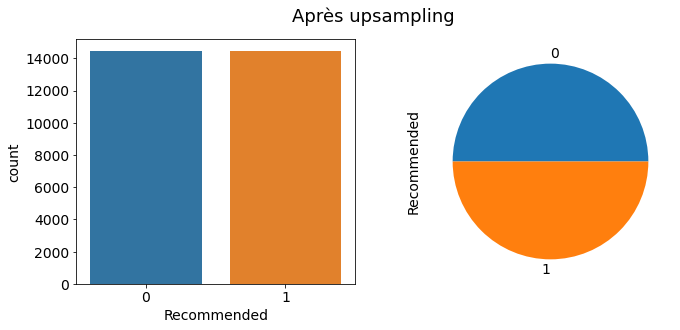

In [151]:
# Even distribution of reviews in our test data set

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

fig = plt.figure(figsize = (11, 4.5))
plt.subplot(1, 2, 1)
sns.countplot(x=df_upsampled['Recommended'])

plt.subplot(1, 2, 2)
df_upsampled['Recommended'].value_counts().plot.pie(y='Class')
fig.suptitle('Après upsampling', fontsize=18)

In [152]:
# Apply cleaning process to reviews : keep only meaningful words 

df_upsampled.reset_index(drop=True, inplace=True)
df_upsampled['Review'] = df_upsampled['Review'].apply(clean_text)


In [153]:
X_train = df_upsampled['Review']
y_train = df_upsampled['Recommended']

count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print('SGDClassifier')
clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=1e-3, max_iter=500, tol=None)
start = time.time()
clf.fit(X_train_tfidf, y_train)
stop = time.time()
y_pred = clf.predict(X_test_tfidf)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Training time: {} s'.format(stop - start))
print('\n')

print('LogisticRegression')
clf = LogisticRegression(solver='lbfgs', max_iter=500)
start = time.time()
clf.fit(X_train_tfidf, y_train)
stop = time.time()
y_pred = clf.predict(X_test_tfidf)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Training time: {} s'.format(stop - start))
print('\n')

print('RandomForestClassifier')
clf = RandomForestClassifier(n_estimators=50)
start = time.time()
clf.fit(X_train_tfidf, y_train)
stop = time.time()
y_pred = clf.predict(X_test_tfidf)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Training time: {} s'.format(stop - start))
print('\n')

print('LinearSVC')
clf = LinearSVC()
start = time.time()
clf.fit(X_train_tfidf, y_train)
stop = time.time()
y_pred = clf.predict(X_test_tfidf)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Training time: {} s'.format(stop - start))

# model = MultinomialNB()
# model.fit(X_train_tfidf, y_train)

SGDClassifier
Accuracy: 0.8654632152588556
Recall: 0.8685513825835741
Precision: 0.9649243466299863
F1 score: 0.9142050390964379
Training time: 2.4385440349578857 s


LogisticRegression
Accuracy: 0.8869209809264306
Recall: 0.9048699958728849
Precision: 0.9557541412380122
F1 score: 0.9296162815348739
Training time: 0.21593976020812988 s


RandomForestClassifier
Accuracy: 0.8831743869209809
Recall: 0.9676021460998762
Precision: 0.8986201609812189
F1 score: 0.9318362480127186
Training time: 3.628319025039673 s


LinearSVC
Accuracy: 0.8830040871934605
Recall: 0.9168386297977713
Precision: 0.9399196107467739
F1 score: 0.9282356628016296
Training time: 0.09220409393310547 s


In [200]:
# Before anything, let's split into test and train data.

df['Review'] = df['Review'].apply(clean_text)
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Recommended'], test_size=0.25, random_state=27)

# Gather X_train and X_test into a dataframe
df_train = pd.concat([X_train, y_train], axis=1)

df_majority = df_train[(df_train['Recommended']==1)]
df_minority = df_train[(df_train['Recommended']==0)]

n_classifiers = 100
list_classifiers = []
list_preds = []

# Training 

start = time.time()
for i in range(n_classifiers):

    # Partitionning
    list_choices = choices(df_majority.index, k=len(df_minority))

    df_majority_downsampled = df_majority.loc[list_choices]

    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    X_train = df_downsampled['Review']
    y_train = df_downsampled['Recommended']

    count_vec = CountVectorizer()
    X_train_counts = count_vec.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    X_test_counts = count_vec.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    
    clf = LinearSVC()
    clf.fit(X_train_tfidf, y_train)
    list_classifiers.append(clf)

    y_pred = clf.predict(X_test_tfidf)
    list_preds.append(y_pred)


stop = time.time()

# y_pred = evclf.predict(X_test_tfidf)
# print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
# print('Recall: {}'.format(recall_score(y_test, y_pred)))
# print('Precision: {}'.format(precision_score(y_test, y_pred)))
# print('F1 score: {}'.format(f1_score(y_test, y_pred)))
# print('Training time: {} s'.format(stop - start))

In [201]:
df_preds = pd.DataFrame.from_records(list_preds)
pred_array = []

for col in df_preds.columns :
    pred_array.append(df_preds[col].value_counts().idxmax())



In [202]:
y_pred = pred_array
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print('Recall: {}'.format(recall_score(y_test, y_pred)))
print('Precision: {}'.format(precision_score(y_test, y_pred)))
print('F1 score: {}'.format(f1_score(y_test, y_pred)))
print('Training time: {} s'.format(stop - start))

Accuracy: 0.8664850136239782
Recall: 0.8689640940982254
Precision: 0.9658256880733945
F1 score: 0.9148381490332392
Training time: 16.730302095413208 s
